In [ ]:
#!pip3 install -U -r requirements.txt

## Data

We work with non-parallel voice conversion. This is more challenging but more valuable given that it s difficult to collect parallel training data of different speakers. 

There are two ways in which non-parallel data is handeled:
1. Convert it into parallel data and then learn mappining functions like 
    1.1 generatinf parallel data through test-to-speech synthesis 
    1.2 frame selection
    1.3 iterative combination of a nearest neighbor search step and a conversion stem alignment 
    1.4 CycleGAN based Voice conversion 
2. Factorize linguistic and speaker related representations carried by acoustic features 
    At conversion stage the linguistic content of the source speaker is tranformed to that of targer speaker 
    

References https://arxiv.org/pdf/1906.10508.pdf


We work with raw speech dataset

In [47]:
import pandas as pd       
import os 
import math 
import numpy as np
import matplotlib.pyplot as plt  
import IPython.display as ipd  # To play sound in the notebook
import librosa
import librosa.display
import os
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchsummary import summary

In [48]:
import random

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
# PATHS 

raw_data = '/home/ubuntu/voice_conversion/data/raw/VCTK-Corpus'
interim_data = os.path.join('/home/ubuntu/voice_conversion/data', 'interim')
spectogram_array_path =  os.path.join(interim_data, 'spectogram_array')
spectogram_array_path_trim_30db =  os.path.join(interim_data, 'spectogram_array_trim_30db')
spectrogram_path =os.path.join(interim_data, 'spectogram') 
audio_path = '/home/ubuntu/voice_conversion/data/raw/VCTK-Corpus/wav48/'
trim_audio_path = '/home/ubuntu/voice_conversion/data/trim_silence_30db'

In [51]:
# MKDIR
if not os.path.exists(interim_data):
    os.makedirs(interim_data)

if not os.path.exists(spectogram_array_path):
    os.mkdir(spectogram_array_path)

In [52]:
if not os.path.exists(spectogram_array_path_trim_30db):
    os.makedirs(spectogram_array_path_trim_30db)

In [53]:
df = pd.read_csv(os.path.join(raw_data,"speaker-info.txt"),delimiter= '\s+', index_col=False)
print(df.columns)
df.describe()

Index(['ID', 'AGE', 'GENDER', 'ACCENTS', 'REGION'], dtype='object')


,ID,AGE
count,108.000000,108.000000
mean,286.120370,22.666667
std,39.629763,3.013986
min,225.000000,18.000000
25%,253.750000,21.000000
50%,281.500000,22.000000
75%,313.250000,23.000000
max,376.000000,38.000000


In [10]:
df.head(10)

,ID,AGE,GENDER,ACCENTS,REGION
0,225,23,F,English,Southern
1,226,22,M,English,Surrey
2,227,38,M,English,Cumbria
3,228,22,F,English,Southern
4,229,23,F,English,Southern
5,230,22,F,English,Stockton-on-tees
6,231,23,F,English,Southern
7,232,23,M,English,Southern
8,233,23,F,English,Staffordshire
9,234,22,F,Scottish,West


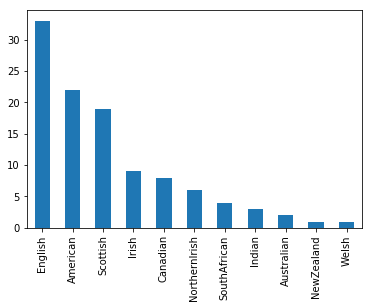

In [11]:
df['ACCENTS'].value_counts().plot(kind = 'bar')

This data contains a very low number of Indian accent English speakers, which in reality is different. 
Source: https://en.wikipedia.org/wiki/List_of_countries_by_English-speaking_population

## Preprocess data

In [12]:
# Below is the accent information 
spk2acc = pd.Series(df.ACCENTS.values,index=df.ID).to_dict()
spk2acc

{225: 'English',
 226: 'English',
 227: 'English',
 228: 'English',
 229: 'English',
 230: 'English',
 231: 'English',
 232: 'English',
 233: 'English',
 234: 'Scottish',
 236: 'English',
 237: 'Scottish',
 238: 'NorthernIrish',
 239: 'English',
 240: 'English',
 241: 'Scottish',
 243: 'English',
 244: 'English',
 245: 'Irish',
 246: 'Scottish',
 247: 'Scottish',
 248: 'Indian',
 249: 'Scottish',
 250: 'English',
 251: 'Indian',
 252: 'Scottish',
 253: 'Welsh',
 254: 'English',
 255: 'Scottish',
 256: 'English',
 257: 'English',
 258: 'English',
 259: 'English',
 260: 'Scottish',
 261: 'NorthernIrish',
 262: 'Scottish',
 263: 'Scottish',
 264: 'Scottish',
 265: 'Scottish',
 266: 'Irish',
 267: 'English',
 268: 'English',
 269: 'English',
 270: 'English',
 271: 'Scottish',
 272: 'Scottish',
 273: 'English',
 274: 'English',
 275: 'Scottish',
 276: 'English',
 277: 'English',
 278: 'English',
 279: 'English',
 281: 'Scottish',
 282: 'English',
 283: 'Irish',
 284: 'Scottish',
 285: 'Scot

In [ ]:
min_length = 256   # Since we slice 256 frames from each utterance when training.
# Build a dict useful when we want to get one-hot representation of speakers.


In [8]:
raw_data

'/home/ubuntu/voice_conversion/data/raw/VCTK-Corpus'

In [14]:
files = librosa.util.find_files(raw_data, ext=['wav']) 
files = np.asarray(files)
file_list = list(files)


In [33]:
random_files

In [41]:
def create_spectrogram_array():

    for audio_file in file_list[:4000]:
        samples, sample_rate = librosa.load(audio_file)
        audio_name = audio_file.split('raw')[1].split('/')[-1].split('.')[0]
        filename  = spectrogram_path + audio_name + '.png'
        X = librosa.stft(samples)
        Xdb = librosa.amplitude_to_db(abs(X))
        np.save(filename, Xdb)

In [42]:
create_spectrogram_array()

In [ ]:
### checking where freq and time goes for each 

In [45]:
# make spectogram array from trimmmed audio files 
def create_spectrogram_array():
    for audio_file in file_list:
        samples, sample_rate = librosa.load(audio_file, sr = 16000)
        audio_name = audio_file.split('trim_silence_30db')[1].split('/')[-1].split('.')[0]
        filename  = os.path.join(spectogram_array_path_trim_30db , 'trim_spec'+ '_'+audio_name)
        X = np.abs(librosa.stft(samples))
        np.save(filename, X)



In [46]:
create_spectrogram_array()

In [ ]:
## load npy file and see how it looks

In [9]:
import os
import glob

files_np = list(glob.glob(os.path.join(spectogram_array_path,'*.*')))

In [15]:
files_np[0]
trial =np.load(files_np[0])

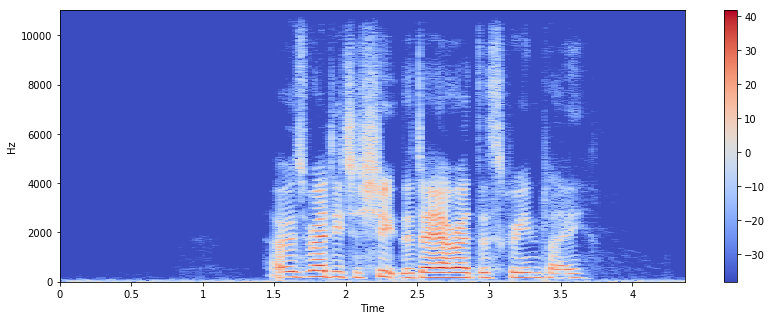

In [16]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(trial, x_axis='time', y_axis='hz')
plt.colorbar()

In [14]:
files_np[0]

'/home/ubuntu/voice_conversion/data/interim/spectogram_array/spectogramp282_237.png.npy'

## to be used later 

In [ ]:
def resample(spk, origin_wavpath, target_wavpath):
    wavfiles = [i for i in os.listdir(join(origin_wavpath, spk)) if i.endswith(".wav")]
    for wav in wavfiles:
        folder_to = join(target_wavpath, spk)
        os.makedirs(folder_to, exist_ok=True)
        wav_to = join(folder_to, wav)
        wav_from = join(origin_wavpath, spk, wav)
        subprocess.call(['sox', wav_from, "-r", "16000", wav_to])
    return 0

def resample_to_16k(origin_wavpath, target_wavpath, num_workers=1):
    os.makedirs(target_wavpath, exist_ok=True)
    spk_folders = os.listdir(origin_wavpath)
    print(f"> Using {num_workers} workers!")
    executor = ProcessPoolExecutor(max_workers=num_workers)
    futures = []
    for spk in spk_folders:
        futures.append(executor.submit(partial(resample, spk, origin_wavpath, target_wavpath)))
    result_list = [future.result() for future in tqdm(futures)]
    print(result_list)

def split_data(paths):
    indices = np.arange(len(paths))
    test_size = 0.1
    train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=1234)
    train_paths = list(np.array(paths)[train_indices])
    test_paths = list(np.array(paths)[test_indices])
    return train_paths, test_paths

def get_spk_world_feats(spk_fold_path, mc_dir_train, mc_dir_test, sample_rate=16000):
    paths = glob.glob(join(spk_fold_path, '*.wav'))
    spk_name = basename(spk_fold_path)
    train_paths, test_paths = split_data(paths)
    f0s = []
    coded_sps = []
    for wav_file in train_paths:
        f0, _, _, _, coded_sp = world_encode_wav(wav_file, fs=sample_rate)
        f0s.append(f0)
        coded_sps.append(coded_sp)
    log_f0s_mean, log_f0s_std = logf0_statistics(f0s)
    coded_sps_mean, coded_sps_std = coded_sp_statistics(coded_sps)
    np.savez(join(mc_dir_train, spk_name+'_stats.npz'), 
            log_f0s_mean=log_f0s_mean,
            log_f0s_std=log_f0s_std,
            coded_sps_mean=coded_sps_mean,
            coded_sps_std=coded_sps_std)
    
    for wav_file in tqdm(train_paths):
        wav_nam = basename(wav_file)
        f0, timeaxis, sp, ap, coded_sp = world_encode_wav(wav_file, fs=sample_rate)
        normed_coded_sp = normalize_coded_sp(coded_sp, coded_sps_mean, coded_sps_std)
        np.save(join(mc_dir_train, wav_nam.replace('.wav', '.npy')), normed_coded_sp, allow_pickle=False)
    
    for wav_file in tqdm(test_paths):
        wav_nam = basename(wav_file)
        f0, timeaxis, sp, ap, coded_sp = world_encode_wav(wav_file, fs=sample_rate)
        normed_coded_sp = normalize_coded_sp(coded_sp, coded_sps_mean, coded_sps_std)
        np.save(join(mc_dir_test, wav_nam.replace('.wav', '.npy')), normed_coded_sp, allow_pickle=False)
    return 0


if __name__ == '__main__':
    parser = argparse.ArgumentParser()


    sample_rate_default = 16000
    origin_wavpath_default = "./data/VCTK-Corpus/wav48"
    target_wavpath_default = "./data/VCTK-Corpus/wav16"
    mc_dir_train_default = './data/mc/train'
    mc_dir_test_default = './data/mc/test'

    parser.add_argument("--sample_rate", type = int, default = 16000, help = "Sample rate.")
    parser.add_argument("--origin_wavpath", type = str, default = origin_wavpath_default, help = "The original wav path to resample.")
    parser.add_argument("--target_wavpath", type = str, default = target_wavpath_default, help = "The original wav path to resample.")
    parser.add_argument("--mc_dir_train", type = str, default = mc_dir_train_default, help = "The directory to store the training features.")
    parser.add_argument("--mc_dir_test", type = str, default = mc_dir_test_default, help = "The directory to store the testing features.")
    parser.add_argument("--num_workers", type = int, default = None, help = "The number of cpus to use.")

    argv = parser.parse_args()

    sample_rate = argv.sample_rate
    origin_wavpath = argv.origin_wavpath
    target_wavpath = argv.target_wavpath
    mc_dir_train = argv.mc_dir_train
    mc_dir_test = argv.mc_dir_test
    num_workers = argv.num_workers if argv.num_workers is not None else cpu_count()

    # The original wav in VCTK is 48K, first we want to resample to 16K
    resample_to_16k(origin_wavpath, target_wavpath, num_workers=num_workers)

    # WE only use 10 speakers listed below for this experiment.
    speaker_used = ['262', '272', '229', '232', '292', '293', '360', '361', '248', '251']
    speaker_used = ['p'+i for i in speaker_used]

    ## Next we are to extract the acoustic features (MCEPs, lf0) and compute the corresponding stats (means, stds). 
    # Make dirs to contain the MCEPs
    os.makedirs(mc_dir_train, exist_ok=True)
    os.makedirs(mc_dir_test, exist_ok=True)

    num_workers = len(speaker_used) #cpu_count()
    print("number of workers: ", num_workers)
    executor = ProcessPoolExecutor(max_workers=num_workers)

    work_dir = target_wavpath
    # spk_folders = os.listdir(work_dir)
    # print("processing {} speaker folders".format(len(spk_folders)))
    # print(spk_folders)

    futures = []
    for spk in speaker_used:
        spk_path = os.path.join(work_dir, spk)
        futures.append(executor.submit(partial(get_spk_world_feats, spk_path, mc_dir_train, mc_dir_test, sample_rate)))
    result_list = [future.result() for future in tqdm(futures)]
    print(result_list)
    sys.exit(0)

## Model

Language is inherently discrete, similarly speech is typically representated as a sequence of symbols. thus it makes sense to focus on Learning representation with discrete representations. 

VQVAE
pros: 
1. does not suffer from large variance 
2. avoids [posterior collapse](https://datascience.stackexchange.com/questions/48962/what-is-posterior-collapse-phenomenon)

VQ-VAE uses latent space in an effective manner: it can model important features which span many dimensions in data space (like phonemes in speech) as opposed to focusing or spending capacity on noise and imperceptible details which are oftern local

Lastly, once a good discrete latent structure of modality is discovered by VQ VAE we train a powerful prior over theses discrete random variables, which can yield interesting samples and useful applications 

When trained on speech one can discover latent structure of language without any supervision or prior knowledge about phonemes or words.  Furthermore we can equip decoder with the speaker identity which could allow for speaker conversion i.e transferrrinf voice from one speaker to another without changing contents. 


Main contribution of VQ VAE 
- when paired with a powerful proir, samples are coherent and hight quality speech generation
- their is some evidence of learning language through raw speech without any supervision and show applications of unsupervised speaker conversion

For speech one actually extracts 1D latent features 



https://blog.usejournal.com/understanding-vector-quantized-variational-autoencoders-vq-vae-323d710a888a

Ref [ELBO](https://medium.com/@hfdtsinghua/derivation-of-elbo-in-vae-25ad7991fdf7)


![Model](VQ_VAE.png)

## Load Data 

In [83]:
import os
import glob

files_np = list(glob.glob(os.path.join(spectogram_array_path,'*.*')))

In [84]:
X_list = []
Y_list = []
for file in files_np[:100]: 
    trial_x = np.load(file)
    trial_x =torch.tensor(trial_x, device=device).float()
    trial_y = file.split('spectogram_array/')[1].split('_')[0][-3:]
    trial_y =torch.tensor(int(trial_y), device=device).float()
    X_list.append(trial_x)
    Y_list.append(trial_y)


In [85]:
nX_list = []
col_shape = []
for file in files_np[:100]: 
    trial_x = np.load(file)
    _, cols = trial_x.shape
    nX_list.append(trial_x)
    col_shape.append(cols)
    

In [86]:
max(col_shape)

326

In [87]:
for i,a in enumerate(nX_list):
  rows, cols = a.shape
  #print(rows, cols)
  if cols != 326:
    nX_list[i] = np.hstack([a, np.zeros(( rows, 326 - cols), dtype=a.dtype)])

In [88]:
X_list = []
for file in nX_list: 
    trial_x =torch.tensor(file, device=device).float()
    X_list.append(trial_x)

In [89]:
rows, cols = nX_list[0].shape

In [90]:
x_Tensor= torch.stack(X_list)

In [32]:
y_Tensor= torch.stack(Y_list)

In [33]:
training_tensordataset = torch.utils.data.TensorDataset(x_Tensor, y_Tensor)

In [34]:
training_loader = torch.utils.data.DataLoader(training_tensordataset, batch_size= 10 , shuffle=True)

## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [94]:
batch_size = 10
num_training_updates = 1500

# Encoder
num_hiddens = 768
num_residual_hiddens = 32
num_residual_layers = 2
# input_dim: 256

# VQ
# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64
# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 29

commitment_cost = 0.25

decay = -0.99

learning_rate = 1e-3

In [92]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, device):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost
        self._device = device

    def forward(self, inputs):
        
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(1, 2, 0).contiguous()
        input_shape = inputs.shape
        
        print('shape of inputs in VectorQuantizer.forward',inputs.shape)
        _, time, batch_size = input_shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        print('shape of flat_input in VectorQuantizer.forward',flat_input.size())
        print('device of flat_input',flat_input.device)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        print('shape of quantized in VectorQuantizer.forward',quantized.size())
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        #print("with inputs quantized: "quantized.size())
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(2, 0, 1).contiguous(), perplexity, encodings

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [19]:
class VectorQuantizerEMA(nn.Module):
    """
    Inspired from Sonnet implementation of VQ-VAE https://arxiv.org/abs/1711.00937,
    in https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py and
    pytorch implementation of it from zalandoresearch in https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb.
    Implements a slightly modified version of the algorithm presented in
    'Neural Discrete Representation Learning' by van den Oord et al.
    https://arxiv.org/abs/1711.00937
    The difference between VectorQuantizerEMA and VectorQuantizer is that
    this module uses exponential moving averages to update the embedding vectors
    instead of an auxiliary loss. This has the advantage that the embedding
    updates are independent of the choice of optimizer (SGD, RMSProp, Adam, K-Fac,
    ...) used for the encoder, decoder and other parts of the architecture. For
    most experiments the EMA version trains faster than the non-EMA version.
    Input any tensor to be quantized. Last dimension will be used as space in
    which to quantize. All other dimensions will be flattened and will be seen
    as different examples to quantize.
    The output tensor will have the same shape as the input.
    For example a tensor with shape [16, 32, 32, 64] will be reshaped into
    [16384, 64] and all 16384 vectors (each of 64 dimensions)  will be quantized
    independently.
    Args:
        embedding_dim: integer representing the dimensionality of the tensors in the
            quantized space. Inputs to the modules must be in this format as well.
        num_embeddings: integer, the number of vectors in the quantized space.
            commitment_cost: scalar which controls the weighting of the loss terms (see
            equation 4 in the paper).
        decay: float, decay for the moving averages.
        epsilon: small float constant to avoid numerical instability.
    """
        
        
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, device, epsilon=1e-5):
           
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon
        self._device = device

    def forward(self, inputs, compute_distances_if_possible=True, record_codebook_stats=False):
        """
        Connects the module to some inputs.
        Args:
            inputs: Tensor, final dimension must be equal to embedding_dim. All other
                leading dimensions will be flattened and treated as a large batch.
        
        Returns:
            loss: Tensor containing the loss to optimize.
            quantize: Tensor containing the quantized version of the input.
            perplexity: Tensor containing the perplexity of the encodings.
            encodings: Tensor containing the discrete encodings, ie which element
                of the quantized space each input element was mapped to.
            distances
        """

        
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(1, 2, 0).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
        """
        encoding_indices: Tensor containing the discrete encoding indices, ie
        which element of the quantized space each input element was mapped to.
        """
        
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, dtype=torch.float).to(self._device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Compute distances between encoding vectors
        if not self.training and compute_distances_if_possible:
            _encoding_distances = [torch.dist(items[0], items[1], 2).to(self._device) for items in combinations(flat_input, r=2)]
            encoding_distances = torch.tensor(_encoding_distances).to(self._device).view(batch_size, -1)
        else:
            encoding_distances = None

        # Compute distances between embedding vectors
        if not self.training and compute_distances_if_possible:
            _embedding_distances = [torch.dist(items[0], items[1], 2).to(self._device) for items in combinations(self._embedding.weight, r=2)]
            embedding_distances = torch.tensor(_embedding_distances).to(self._device)
        else:
            embedding_distances = None

        # Sample nearest embedding
        if not self.training and compute_distances_if_possible:
            _frames_vs_embedding_distances = [torch.dist(items[0], items[1], 2).to(self._device) for items in product(flat_input, self._embedding.weight.detach())]
            frames_vs_embedding_distances = torch.tensor(_frames_vs_embedding_distances).to(self._device).view(batch_size, time, -1)
        else:
            frames_vs_embedding_distances = None
        
        
        

        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        concatenated_quantized = self._embedding.weight[torch.argmin(distances, dim=1).detach().cpu()] if not self.training or record_codebook_stats else None
        
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        """
        The perplexity a useful value to track during training.
        It indicates how many codes are 'active' on average.
        """
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(2, 0, 1).contiguous(), perplexity, encodings

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [20]:
def print_att(obj):
    return [i for i in obj if '__' not in i]

In [22]:
torch.zeros(num_residual_layers * num_residual_hiddens, 10, num_hiddens).size()

torch.Size([64, 10, 768])

In [35]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()
        
        """
        2 preprocessing convolution layers with filter length 3
        and residual connections.
        """
        

        self._conv_1 = nn.Conv1d(in_channels= 1025, #??features_filters,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 padding=1)
        
        self._conv_2 = nn.Conv1d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 padding=1)
        """
        1 strided convolution length reduction layer with filter
        length 4 and stride 2 (downsampling the signal by a factor
        of two).
        """
        
        self._conv_3 = nn.Conv1d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=1, 
                                 padding=2)
        """
        2 convolutional layers with length 3 and
        residual connections.
        """
        self._conv_4 = nn.Conv1d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 padding=1)
        
        self._conv_5 = nn.Conv1d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        print('shape of inputs in Encoder.forward',inputs.size())

        x_conv_1 = F.relu(self._conv_1(inputs))
        print('shape of x in Encoder.forward._conv_1',x_conv_1.size())

        x = F.relu(self._conv_2(x_conv_1)) + x_conv_1
        print('shape of x in Encoder.forward.relu_2',x.size())
        
        x_conv_3 = F.relu(self._conv_3(x))
        print('shape of x in Encoder.forward._conv_3',x.size())
        
        x_conv_4 = F.relu(self._conv_4(x_conv_3)) + x_conv_3
        
        x_conv_5 = F.relu(self._conv_5(x_conv_4)) + x_conv_4
        
        x = self._residual_stack(x_conv_5) + x_conv_5
        
        return x

In [21]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        
        super(Residual, self).__init__()
        
        self._block = nn.Sequential(
            
            nn.ReLU(True),
            
            nn.Conv1d(
                     in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, 
                      stride=1, 
                      padding=1, 
                      bias=False),
            
            nn.ReLU(True),
            
            nn.Conv1d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, 
                      stride=1, 
                      bias=False)
        )
    
    def forward(self, x):
        print('shape of x in Residual.forward',x.size())
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        print('shape of x in ResidualStack.forward',x.size())
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
            print(f'Iteration {i} shape of x in ResidualStack.forward {x.size()} ',)
        return F.relu(x)

In [ ]:
class Decoderold(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        #self._conv_1 = nn.Conv1d(in_channels=in_channels,
        #                        out_channels=num_hiddens,
        #                         kernel_size=3,
        #                         padding=1)
        
        #self._upsample = nn.Upsample(scale_factor=2)
        
        self._residual_stack = ResidualStack(in_channels=in_channels,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens,
                                                kernel_size=3, 
                                                padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens,
                                                kernel_size=3,  
                                                padding=1)
        
        self._conv_trans_3 = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens,#out_channels
                                                kernel_size=4, 
                                                stride=1, 
                                                padding=2)
        
        
        self._conv_trans_4 = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens,#out_channels
                                                kernel_size=3, 
                                                padding=1)
        
        self._conv_trans_5 = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=1025,#out_channels
                                                kernel_size=3, 
                                                padding=1)
        
        
        
        

    def forward(self, inputs):
        
        x = self._residual_stack(inputs)
        
        x = F.relu(self._conv_trans_1(x))
        
        x = F.relu(self._conv_trans_2(x))
        
        x = F.relu(self._conv_trans_3(x)) 
        
        x = F.relu(self._conv_trans_4(x)) 
        
        
        x = self._conv_trans_5(x)

        
        return x

In [127]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        #self._conv_1 = nn.Conv1d(in_channels=in_channels,
        #                        out_channels=num_hiddens,
        #                         kernel_size=3,
        #                         padding=1)
        
        #self._upsample = nn.Upsample(scale_factor=2)
        
        self._residual_stack = ResidualStack(in_channels=in_channels,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens,
                                                kernel_size=3, 
                                                padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens,
                                                kernel_size=3,  
                                                padding=1)
        
        self._conv_trans_3 = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens,#out_channels
                                                kernel_size=4, 
                                                stride=1, 
                                                padding=2)
        
        
        self._conv_trans_4 = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens,#out_channels
                                                kernel_size=3, 
                                                padding=1)
        
        self._conv_trans_5 = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=1025,#out_channels
                                                kernel_size=3, 
                                                padding=1)
        
        
        
        

    def forward(self, inputs):
        
        x = self._residual_stack(inputs)
        
        x = F.relu(self._conv_trans_1(x))
        
        x = F.relu(self._conv_trans_2(x))
        
        x = F.relu(self._conv_trans_3(x)) 
        
        x = F.relu(self._conv_trans_4(x)) 
        
        
        x = self._conv_trans_5(x)

        
        return x

## Train

We use the hyperparameters from the author's code:

In [128]:
#training_loader = DataLoader(training_data, 
#                             batch_size=batch_size, 
#                             shuffle=True,
#                             pin_memory=True)

In [129]:
#validation_loader = DataLoader(validation_data,
#                               batch_size=32,
#                               shuffle=True,
#                               pin_memory=True)

In [130]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(1, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv1d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost, device)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        print("Model::forward")
        #print(x.size())
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        #print("quantized ")
        #print( quantized.size())
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [131]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [132]:
summary(model, (1025, 326))

Model::forward
shape of inputs in Encoder.forward torch.Size([2, 1025, 326])
shape of x in Encoder.forward._conv_1 torch.Size([2, 768, 326])
shape of x in Encoder.forward.relu_2 torch.Size([2, 768, 326])
shape of x in Encoder.forward._conv_3 torch.Size([2, 768, 326])
shape of x in ResidualStack.forward torch.Size([2, 768, 327])
shape of x in Residual.forward torch.Size([2, 768, 327])
Iteration 0 shape of x in ResidualStack.forward torch.Size([2, 768, 327]) 
shape of x in Residual.forward torch.Size([2, 768, 327])
Iteration 1 shape of x in ResidualStack.forward torch.Size([2, 768, 327]) 
shape of inputs in VectorQuantizer.forward torch.Size([64, 327, 2])
shape of flat_input in VectorQuantizer.forward torch.Size([654, 64])
device of flat_input cuda:0
shape of quantized in VectorQuantizer.forward torch.Size([64, 327, 2])
shape of x in ResidualStack.forward torch.Size([2, 64, 327])
shape of x in Residual.forward torch.Size([2, 64, 327])


RuntimeError: The size of tensor a (64) must match the size of tensor b (768) at non-singleton dimension 1

In [133]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [134]:
for i in training_loader:
    train = i
    break

In [135]:
np.shape(train)

(2,)

In [136]:
train[0].size()

torch.Size([10, 1025, 326])

In [137]:
train[1].size()

torch.Size([10])

In [138]:
enc = Encoder(1, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens).to(device)

In [139]:
enc._conv_1(train[0])

tensor([[[ 4.9021e+01,  5.4998e+01,  5.4853e+01,  ...,  1.6343e-02,
           1.6343e-02,  1.6343e-02],
         [ 7.1927e+00,  3.2089e+01,  3.2653e+01,  ..., -4.2159e-03,
          -4.2159e-03, -4.2159e-03],
         [-8.7541e+00,  2.4663e-02,  5.3601e-01,  ...,  6.8095e-03,
           6.8095e-03,  6.8095e-03],
         ...,
         [-3.1715e-01,  6.6073e+00,  7.2175e+00,  ..., -7.5450e-04,
          -7.5450e-04, -7.5450e-04],
         [-1.5173e+01, -2.7055e+00, -2.7532e+00,  ..., -8.8941e-03,
          -8.8941e-03, -8.8941e-03],
         [-5.4903e+01, -6.2921e+01, -6.2026e+01,  ..., -2.0041e-03,
          -2.0041e-03, -2.0041e-03]],

        [[ 4.6748e+01,  5.1585e+01,  5.1246e+01,  ...,  1.6343e-02,
           1.6343e-02,  1.6343e-02],
         [ 7.3768e+00,  3.0551e+01,  3.0638e+01,  ..., -4.2159e-03,
          -4.2159e-03, -4.2159e-03],
         [-8.4223e+00,  1.3151e+00,  7.8378e-01,  ...,  6.8095e-03,
           6.8095e-03,  6.8095e-03],
         ...,
         [ 4.8534e-01,  7

In [140]:
enc.forward(train[0]).shape

shape of inputs in Encoder.forward torch.Size([10, 1025, 326])
shape of x in Encoder.forward._conv_1 torch.Size([10, 768, 326])
shape of x in Encoder.forward.relu_2 torch.Size([10, 768, 326])
shape of x in Encoder.forward._conv_3 torch.Size([10, 768, 326])
shape of x in ResidualStack.forward torch.Size([10, 768, 327])
shape of x in Residual.forward torch.Size([10, 768, 327])
Iteration 0 shape of x in ResidualStack.forward torch.Size([10, 768, 327]) 
shape of x in Residual.forward torch.Size([10, 768, 327])
Iteration 1 shape of x in ResidualStack.forward torch.Size([10, 768, 327]) 


torch.Size([10, 768, 327])

In [141]:
model.forward(train[0])

Model::forward
shape of inputs in Encoder.forward torch.Size([10, 1025, 326])
shape of x in Encoder.forward._conv_1 torch.Size([10, 768, 326])
shape of x in Encoder.forward.relu_2 torch.Size([10, 768, 326])
shape of x in Encoder.forward._conv_3 torch.Size([10, 768, 326])
shape of x in ResidualStack.forward torch.Size([10, 768, 327])
shape of x in Residual.forward torch.Size([10, 768, 327])
Iteration 0 shape of x in ResidualStack.forward torch.Size([10, 768, 327]) 
shape of x in Residual.forward torch.Size([10, 768, 327])
Iteration 1 shape of x in ResidualStack.forward torch.Size([10, 768, 327]) 
shape of inputs in VectorQuantizer.forward torch.Size([64, 327, 10])
shape of flat_input in VectorQuantizer.forward torch.Size([3270, 64])
device of flat_input cuda:0
shape of quantized in VectorQuantizer.forward torch.Size([64, 327, 10])
shape of x in ResidualStack.forward torch.Size([10, 64, 327])
shape of x in Residual.forward torch.Size([10, 64, 327])


RuntimeError: The size of tensor a (64) must match the size of tensor b (768) at non-singleton dimension 1

In [142]:
pre_vq_conv = nn.Conv1d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)

In [143]:
x = model._encoder(train[0])
x = model._pre_vq_conv(x)
_,x,_,_ = model._vq_vae(x)
x = model._decoder(x)

shape of inputs in Encoder.forward torch.Size([10, 1025, 326])
shape of x in Encoder.forward._conv_1 torch.Size([10, 768, 326])
shape of x in Encoder.forward.relu_2 torch.Size([10, 768, 326])
shape of x in Encoder.forward._conv_3 torch.Size([10, 768, 326])
shape of x in ResidualStack.forward torch.Size([10, 768, 327])
shape of x in Residual.forward torch.Size([10, 768, 327])
Iteration 0 shape of x in ResidualStack.forward torch.Size([10, 768, 327]) 
shape of x in Residual.forward torch.Size([10, 768, 327])
Iteration 1 shape of x in ResidualStack.forward torch.Size([10, 768, 327]) 
shape of inputs in VectorQuantizer.forward torch.Size([64, 327, 10])
shape of flat_input in VectorQuantizer.forward torch.Size([3270, 64])
device of flat_input cuda:0
shape of quantized in VectorQuantizer.forward torch.Size([64, 327, 10])
shape of x in ResidualStack.forward torch.Size([10, 64, 327])
shape of x in Residual.forward torch.Size([10, 64, 327])


RuntimeError: The size of tensor a (64) must match the size of tensor b (768) at non-singleton dimension 1

In [97]:
vq_vae = VectorQuantizer(num_embeddings, embedding_dim, 
                                              commitment_cost, decay, device)

TypeError: __init__() takes 5 positional arguments but 6 were given

In [98]:
vq_vae.forward(enc.forward(train[0]))

shape of inputs in Encoder.forward torch.Size([10, 1025, 326])
shape of x in Encoder.forward._conv_1 torch.Size([10, 768, 326])
shape of x in Encoder.forward.relu_2 torch.Size([10, 768, 326])
shape of x in Encoder.forward._conv_3 torch.Size([10, 768, 326])
shape of x in ResidualStack.forward torch.Size([10, 768, 327])
shape of x in Residual.forward torch.Size([10, 768, 327])
Iteration 0 shape of x in ResidualStack.forward torch.Size([10, 768, 327]) 
shape of x in Residual.forward torch.Size([10, 768, 327])
Iteration 1 shape of x in ResidualStack.forward torch.Size([10, 768, 327]) 


RuntimeError: expected device cuda:0 but got device cpu

In [104]:
vq_vae

VectorQuantizerEMA(
  (_embedding): Embedding(29, 64)
)

In [ ]:
vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)

In [132]:
res  = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

In [69]:
res.forward(train[0])

NameError: name 'res' is not defined

In [109]:
data_recon.shape

torch.Size([10, 768, 656])

In [110]:
data.shape

torch.Size([10, 1025, 326])

In [120]:
summary(model,(768, 1025, 3))

Model::forward
shape of inputs in Encoder.forward torch.Size([2, 768, 1025, 3])


RuntimeError: Expected 3-dimensional input for 3-dimensional weight 768 1025 3, but got 4-dimensional input of size [2, 768, 1025, 3] instead

In [108]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()
    print("Data size")
    print(data.size())

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

Data size
torch.Size([10, 1025, 326])
Model::forward
shape of inputs in Encoder.forward torch.Size([10, 1025, 326])
shape of x in Encoder.forward._conv_1 torch.Size([10, 768, 326])
shape of x in Encoder.forward.relu_2 torch.Size([10, 768, 326])
shape of x in Encoder.forward._conv_3 torch.Size([10, 768, 326])
shape of x in ResidualStack.forward torch.Size([10, 768, 327])
shape of x in Residual.forward torch.Size([10, 768, 327])
Iteration 0 shape of x in ResidualStack.forward torch.Size([10, 768, 327]) 
shape of x in Residual.forward torch.Size([10, 768, 327])
Iteration 1 shape of x in ResidualStack.forward torch.Size([10, 768, 327]) 
shape of x in ResidualStack.forward torch.Size([10, 768, 654])
shape of x in Residual.forward torch.Size([10, 768, 654])
Iteration 0 shape of x in ResidualStack.forward torch.Size([10, 768, 654]) 
shape of x in Residual.forward torch.Size([10, 768, 654])
Iteration 1 shape of x in ResidualStack.forward torch.Size([10, 768, 654]) 


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Using a target size (torch.Size([10, 1025, 326])) that is different to the input size (torch.Size([10, 768, 656])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  del sys.path[0]


RuntimeError: The size of tensor a (656) must match the size of tensor b (326) at non-singleton dimension 2

## Plot Loss

In [17]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

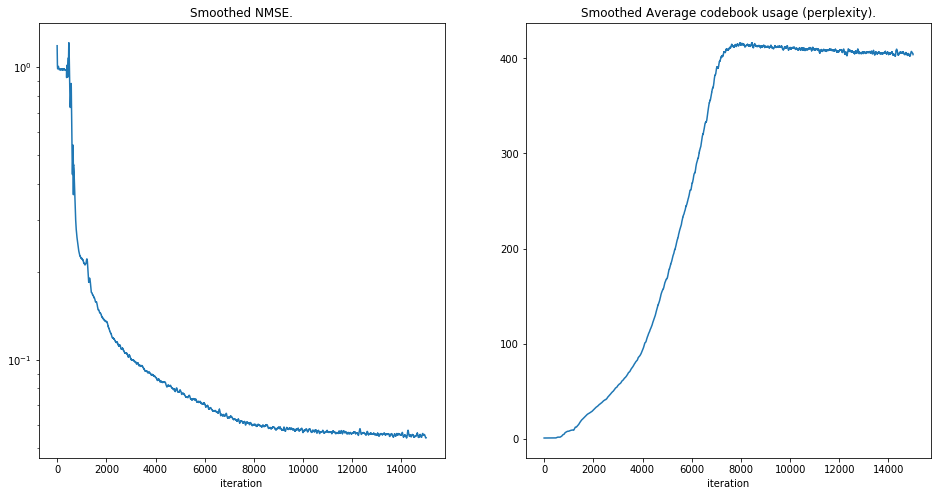

In [18]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Reconstructions

In [19]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [20]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [21]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


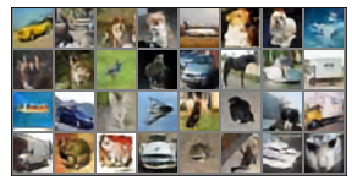

In [22]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

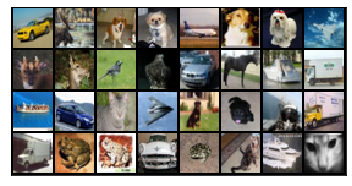

In [23]:
show(make_grid(valid_originals.cpu()+0.5))

## View Embedding

In [24]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

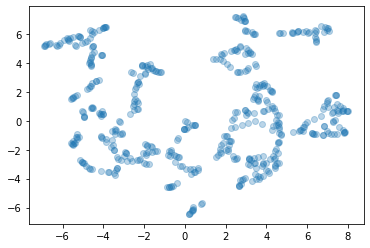

In [25]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)